In [1]:
from obspy.core import Stream, read
import numpy as np
from pytensor.compile.ops import as_op
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import pandas as pd
import os 
import os.path
import pymc as pm
import arviz as az

In [2]:
# What exactly are the colunns here? Amplitude of waves at a specific time?
# My equivalent = peak strain at a specific time

# Build the target function, misfit to this is what is being minimized
@as_op(itypes=[pt.dvector,pt.dscalar,pt.dscalar,pt.dscalar,pt.dscalar,pt.dscalar], otypes=[pt.dvector]) # input variable types and output variable type(s)
def two_straight_lines(x,m1,m2,xinter,x0,y0):
    '''
    input x coordiantes are in x
    slopes are m1 and m2
    intercept of left hand line is b1 
    intersection of two lines is at xinter
    
    Note that y intercept of second straight line is dependent on b1 and xinter
      and defined entirely by them (so that the lines touch).
    '''
    
    # Output vector
    y_out = np.ones(len(x))
    
    # Before building the first straight line, calculate the intercept
    b1 = y0 - m1*x0
    
    # Build first straight line segment
    y_out = m1*x + b1
    
    # Find points that are after the intersection and make the second segment
    i = np.where(x>xinter)[0]
    
    # Define second y intercept
    b2 = m1*xinter + b1 - m2*xinter
    # print(b2)
    
    # Make second straight line
    y_out[i] = m2*x[i] + b2

    return y_out

# Build the target function, misfit to this is what is being minimized
def non_pytensor_two_straight_lines(x,m1,m2,xinter,x0,y0):
    '''
    input x coordiantes are in x
    slopes are m1 and m2
    intercept of left hand line is b1 
    intersection of two lines is at xinter
    
    Note that y intercept of second straight line is dependent on b1 and xinter
      and defined entirely by them (so that the lines touch).
    '''
    
    # Output vector
    yout = np.ones(len(x))
    
    # Before building the first straight line, calculate the intercept
    b1 = y0 - m1*x0
    
    # Build first straight line segment
    yout = m1*x + b1
    
    # Find points that are after the intersection and make the second segment
    i = np.where(x>xinter)[0]
    
    # Define second y intercept
    b2 = m1*xinter + b1 - m2*xinter
    
    # Make second straight line
    yout[i] = m2*x[i] + b2

    return yout

In [3]:
path = '/Users/sydneydybing/SW4/strain/experiments/realistic_eq_sizes/'

rupt_params = np.load(path + 'rupture_params.npy')
print(rupt_params)

# 0. Mw
# 1. Length (km)
# 2. Average slip (m)
# 3. Rise time (s)

# Common hypocenter

hypocenter = [-117.6204, 35.7793, 7.5]

# Stations
stas = pd.read_csv(path + 'stas_w_p_s_traveltimes.csv')
stas_sub = ['E144', 'E126', 'E108', 'E90', 'E72', 'E54', 'E36', 'E18']
stas_sub.reverse()
print(stas_sub)

[[5.00000000e+00 3.38844156e+00 1.51356125e-02 3.35853594e-01]
 [6.00000000e+00 1.41253754e+01 1.20226443e-01 9.23953255e-01]
 [7.00000000e+00 5.88843655e+01 9.54992586e-01 2.54185048e+00]
 [8.00000000e+00 2.45470892e+02 7.58577575e+00 6.99278217e+00]]
['E18', 'E36', 'E54', 'E72', 'E90', 'E108', 'E126', 'E144']


In [4]:
stas

,name,lon,lat,hypo_dist_km,p_arrival,s_arrival
0,E1,-118.5,35.0,117.735516,19.484985,33.835013
1,E2,-118.5,35.1,109.811069,18.258040,31.667682
2,E3,-118.5,35.2,102.476405,17.099509,29.636367
3,E4,-118.5,35.3,95.867056,16.055540,27.802686
4,E5,-118.5,35.4,90.142773,15.151369,26.214599
...,...,...,...,...,...,...
318,E319,-116.7,36.2,95.223479,15.953885,27.624136
319,E320,-116.7,36.3,101.083463,16.879489,29.249912
320,E321,-116.7,36.4,107.770552,17.935735,31.105169
321,E322,-116.7,36.5,115.140783,19.089840,33.125357


In [5]:
def get_xhigh(evt_id, sta):
    
    if sta == 'E144':
        if evt_id == 'M5' or evt_id == 'M6':
            xlim_high = 4
        elif evt_id == 'M7':
            xlim_high = 5
        else:
            xlim_high = 6
    elif sta == 'E126':
        if evt_id == 'M5' or evt_id == 'M6':
            xlim_high = 7
        elif evt_id == 'M7':
            xlim_high = 8
        else:
            xlim_high = 10
    elif sta == 'E108':
        if evt_id == 'M5' or evt_id == 'M6':
            xlim_high = 10
        elif evt_id == 'M7':
            xlim_high = 12
        else:
            xlim_high = 13
    elif sta == 'E90':
        if evt_id == 'M5' or evt_id == 'M6':
            xlim_high = 12
        elif evt_id == 'M7':
            xlim_high = 14
        else:
            xlim_high = 17
    elif sta == 'E72':
        if evt_id == 'M5' or evt_id == 'M6':
            xlim_high = 15
        elif evt_id == 'M7':
            xlim_high = 19
        else:
            xlim_high = 20
    elif sta == 'E54':
        if evt_id == 'M5' or evt_id == 'M6':
            xlim_high = 19
        elif evt_id == 'M7':
            xlim_high = 22
        else:
            xlim_high = 24
    elif sta == 'E36':
        if evt_id == 'M5' or evt_id == 'M6':
            xlim_high = 20
        elif evt_id == 'M7':
            xlim_high = 24
        else:
            xlim_high = 26
    elif sta == 'E18':
        if evt_id == 'M5' or evt_id == 'M6':
            xlim_high = 25
        elif evt_id == 'M7':
            xlim_high = 25
        else:
            xlim_high = 30
    else:
        print('error')
    return xlim_high

M5
Processing E18
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 133 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


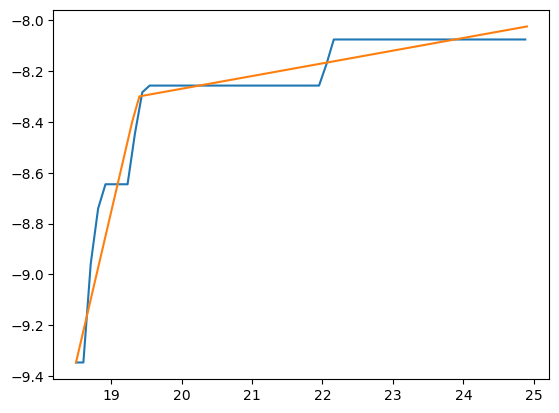

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.188  0.055   1.093    1.295      0.006    0.004     105.0   
m2       0.050  0.006   0.039    0.062      0.000    0.000     419.0   
xinter  19.382  0.047  19.283   19.463      0.005    0.003      96.0   
sigma    0.070  0.007   0.058    0.083      0.000    0.000    6619.0   

        ess_tail  r_hat  
m1         181.0   1.01  
m2         971.0   1.01  
xinter     177.0   1.01  
sigma    10560.0   1.00  
Processing E36
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 139 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


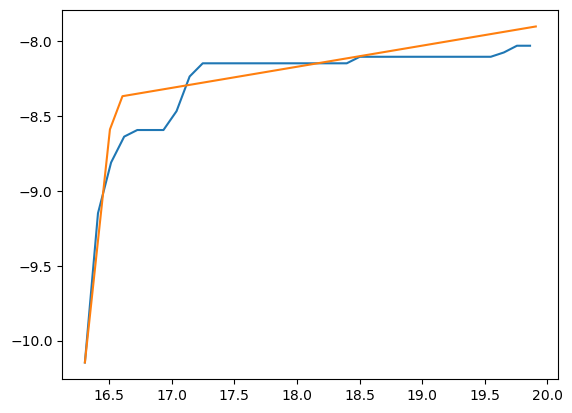

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       7.781  1.511   5.819   10.992      0.307    0.223      35.0   
m2       0.141  0.025   0.094    0.188      0.002    0.001     167.0   
xinter  16.534  0.041  16.455   16.598      0.008    0.006      34.0   
sigma    0.129  0.017   0.099    0.161      0.000    0.000    2472.0   

        ess_tail  r_hat  
m1          59.0   1.15  
m2        1970.0   1.02  
xinter      58.0   1.14  
sigma     7216.0   1.00  
Processing E54
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 138 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


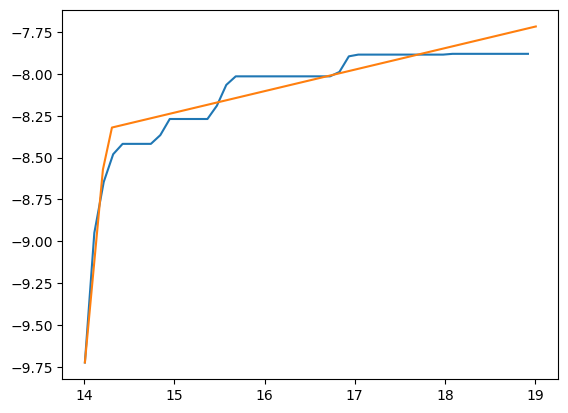

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       5.764  0.731   4.701    7.542      0.146    0.106      38.0   
m2       0.128  0.011   0.109    0.149      0.001    0.000     315.0   
xinter  14.249  0.029  14.181   14.295      0.005    0.004      38.0   
sigma    0.092  0.010   0.074    0.111      0.000    0.000    2992.0   

        ess_tail  r_hat  
m1          32.0   1.05  
m2         375.0   1.01  
xinter      29.0   1.05  
sigma     7526.0   1.00  
Processing E72
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 128 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


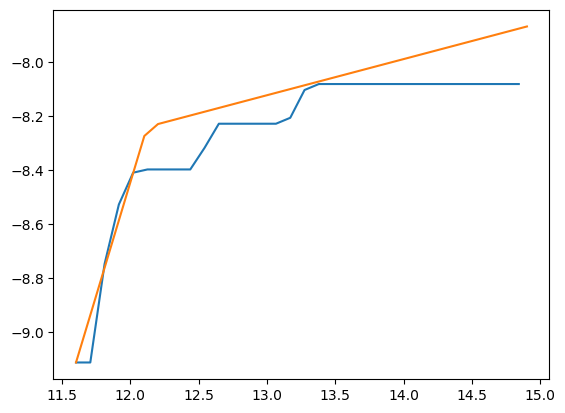

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.681  0.197   1.415    1.996      0.028    0.020      88.0   
m2       0.134  0.114   0.092    0.158      0.009    0.008     625.0   
xinter  12.123  0.672  11.965   12.156      0.092    0.066      87.0   
sigma    0.071  0.027   0.051    0.087      0.004    0.003     586.0   

        ess_tail  r_hat  
m1          97.0   1.05  
m2         425.0   1.01  
xinter      86.0   1.05  
sigma      184.0   1.01  
Processing E90
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 134 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


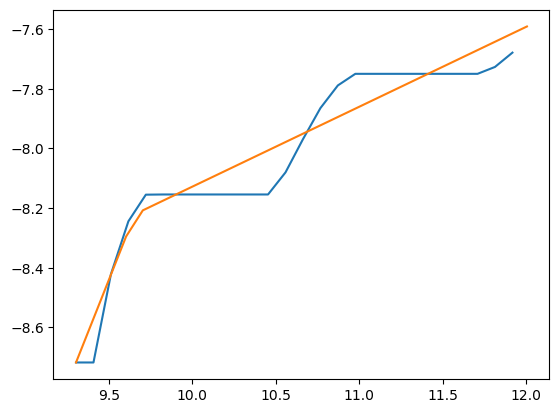

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
m1      1.409  0.261   0.979    1.858      0.015    0.011     355.0     425.0   
m2      0.268  0.026   0.216    0.317      0.001    0.000    1632.0    3186.0   
xinter  9.656  0.076   9.519    9.799      0.004    0.003     372.0     477.0   
sigma   0.084  0.013   0.060    0.109      0.000    0.000    2819.0    4247.0   

        r_hat  
m1       1.01  
m2       1.00  
xinter   1.01  
sigma    1.00  
Processing E108
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 125 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


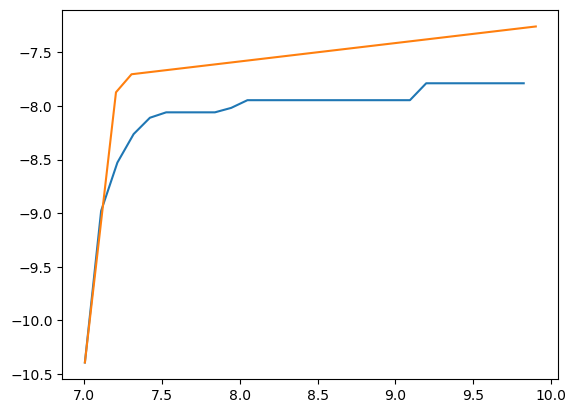

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1      12.598  2.057   9.204   15.111      0.824    0.621       8.0   
m2       0.171  0.055   0.108    0.217      0.002    0.001      28.0   
xinter   7.216  0.534   7.144    7.245      0.057    0.041       8.0   
sigma    0.100  0.073   0.065    0.124      0.010    0.007      31.0   

        ess_tail  r_hat  
m1          36.0   1.45  
m2          60.0   1.10  
xinter      34.0   1.45  
sigma       76.0   1.08  
Processing E126
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 125 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


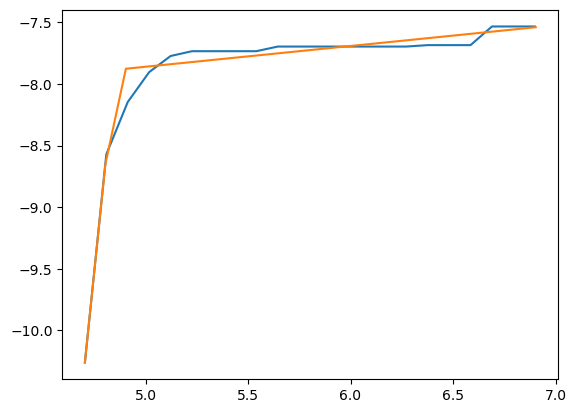

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1      16.106  0.844  14.530   17.772      0.114    0.081      52.0   
m2       0.169  0.033   0.103    0.229      0.001    0.001    1188.0   
xinter   4.851  0.008   4.836    4.868      0.001    0.001      50.0   
sigma    0.088  0.016   0.061    0.117      0.000    0.000    2281.0   

        ess_tail  r_hat  
m1         161.0   1.06  
m2        3132.0   1.01  
xinter     161.0   1.06  
sigma     3507.0   1.00  
Processing E144
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 134 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


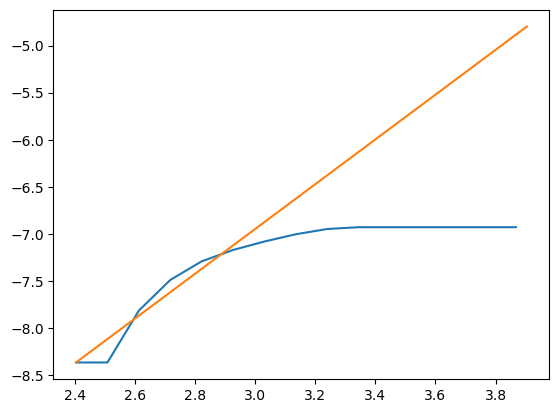

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
m1      2.378  0.400   1.243    2.853      0.159    0.118      14.0      11.0   
m2      0.241  0.378  -0.439    0.748      0.088    0.066     118.0      13.0   
xinter  3.954  3.550   2.711   10.547      1.283    0.944      14.0      14.0   
sigma   0.131  0.096   0.057    0.367      0.039    0.029      15.0      11.0   

        r_hat  
m1       1.21  
m2       1.13  
xinter   1.21  
sigma    1.19  
M6
Processing E18
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 128 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


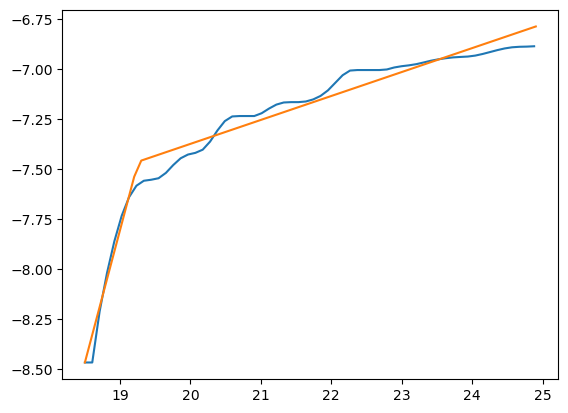

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.327  0.069   1.206    1.466      0.011    0.008      42.0   
m2       0.120  0.005   0.110    0.129      0.000    0.000     237.0   
xinter  19.259  0.048  19.158   19.338      0.008    0.005      40.0   
sigma    0.061  0.006   0.050    0.071      0.000    0.000    4808.0   

        ess_tail  r_hat  
m1         133.0   1.07  
m2         782.0   1.02  
xinter     115.0   1.08  
sigma     9301.0   1.00  
Processing E36
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 132 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


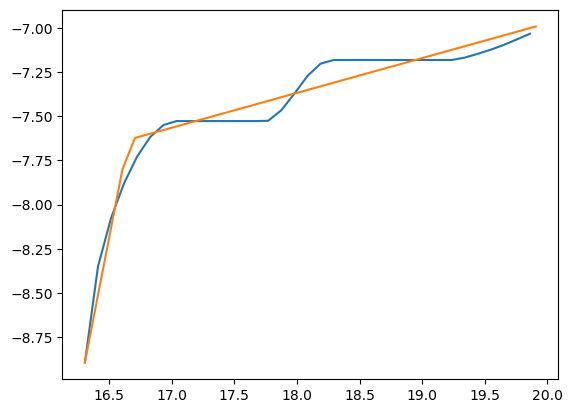

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       3.646  0.307   3.179    4.374      0.049    0.035      56.0   
m2       0.197  0.016   0.167    0.227      0.001    0.001     351.0   
xinter  16.652  0.032  16.579   16.702      0.005    0.004      44.0   
sigma    0.078  0.010   0.061    0.098      0.000    0.000    2559.0   

        ess_tail  r_hat  
m1         107.0   1.12  
m2        1033.0   1.03  
xinter     103.0   1.13  
sigma     5839.0   1.00  
Processing E54
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 141 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


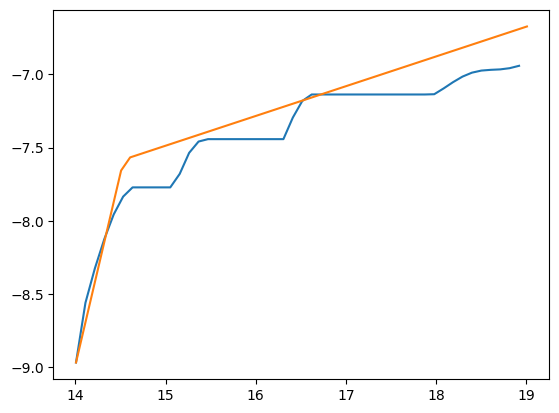

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.621  0.304   2.258    3.165      0.042    0.030      69.0   
m2       0.203  0.104   0.172    0.215      0.008    0.007     425.0   
xinter  14.536  0.630  14.378   14.562      0.081    0.057      68.0   
sigma    0.093  0.040   0.070    0.108      0.006    0.004     460.0   

        ess_tail  r_hat  
m1          47.0   1.09  
m2         499.0   1.01  
xinter      43.0   1.08  
sigma      172.0   1.01  
Processing E72
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 139 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


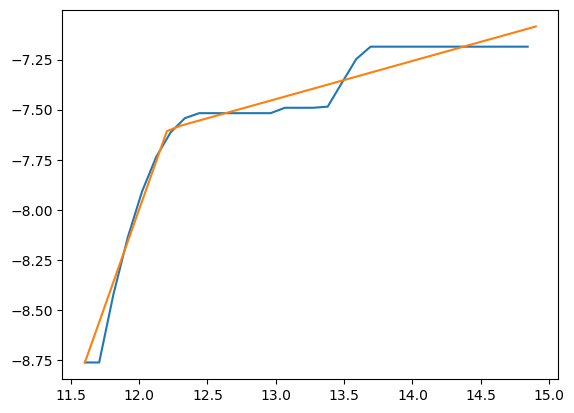

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.926  0.094   1.757    2.103      0.007    0.005     173.0   
m2       0.191  0.019   0.155    0.226      0.001    0.000    1160.0   
xinter  12.207  0.038  12.138   12.280      0.003    0.002     180.0   
sigma    0.076  0.010   0.058    0.096      0.000    0.000    4480.0   

        ess_tail  r_hat  
m1         622.0   1.03  
m2        2197.0   1.00  
xinter     646.0   1.03  
sigma     7215.0   1.00  
Processing E90
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 137 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


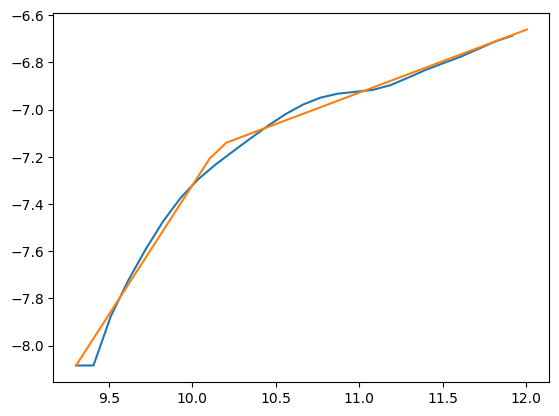

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.096  0.036   1.037    1.173      0.003    0.002     180.0   
m2       0.267  0.020   0.229    0.302      0.001    0.001     483.0   
xinter  10.152  0.051  10.052   10.237      0.004    0.003     174.0   
sigma    0.038  0.006   0.028    0.049      0.000    0.000    3202.0   

        ess_tail  r_hat  
m1         386.0   1.01  
m2        1343.0   1.01  
xinter     379.0   1.01  
sigma     5713.0   1.00  
Processing E108
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 143 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


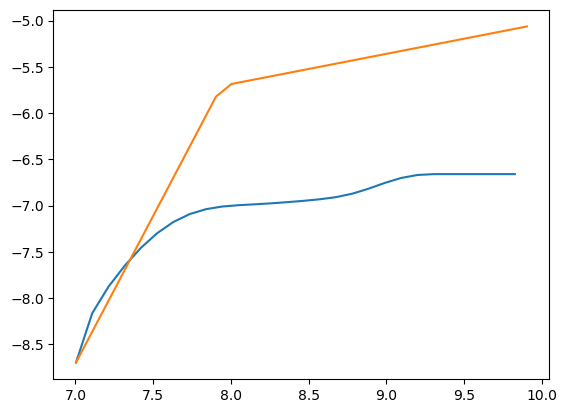

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
m1      3.194  0.539   2.763    4.035      0.138    0.100      48.0      11.0   
m2      0.327  0.375   0.192    0.326      0.092    0.066     124.0      15.0   
xinter  7.940  2.257   7.343    7.550      0.623    0.451      47.0      11.0   
sigma   0.100  0.111   0.050    0.109      0.033    0.024      33.0      11.0   

        r_hat  
m1       1.13  
m2       1.08  
xinter   1.14  
sigma    1.08  
Processing E126
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 144 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


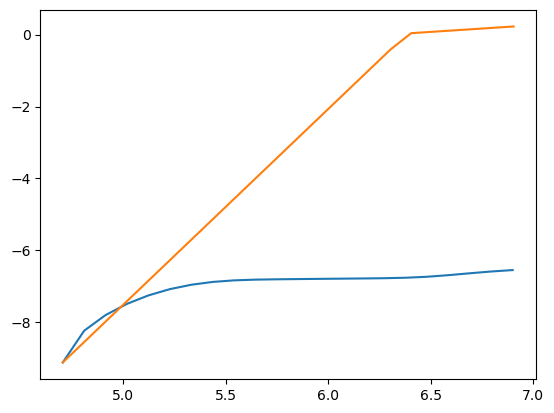

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
m1      5.437  1.394   1.350    6.957      0.599    0.448      12.0      11.0   
m2      0.372  0.500  -0.567    0.957      0.089    0.082     145.0      13.0   
xinter  6.385  4.257   4.934   16.847      1.704    1.266      12.0      15.0   
sigma   0.189  0.222   0.070    0.789      0.098    0.073      13.0      11.0   

        r_hat  
m1       1.25  
m2       1.18  
xinter   1.25  
sigma    1.21  
Processing E144
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 142 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


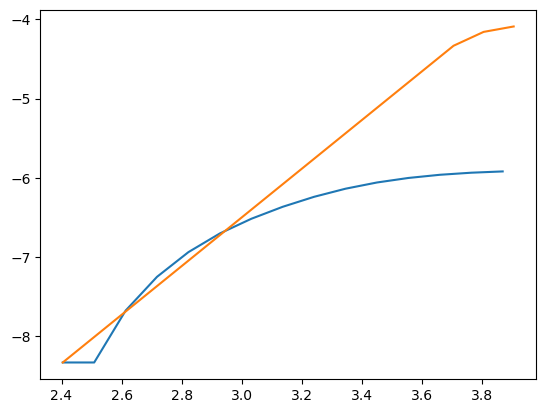

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
m1      3.073  0.300   2.501    3.731      0.076    0.055      45.0      11.0   
m2      0.683  0.398   0.068    1.132      0.053    0.058     200.0      32.0   
xinter  3.749  3.267   2.822    3.316      0.944    0.685      41.0      11.0   
sigma   0.143  0.079   0.064    0.252      0.023    0.017      36.0      12.0   

        r_hat  
m1       1.07  
m2       1.06  
xinter   1.08  
sigma    1.08  
M7
Processing E18
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 153 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


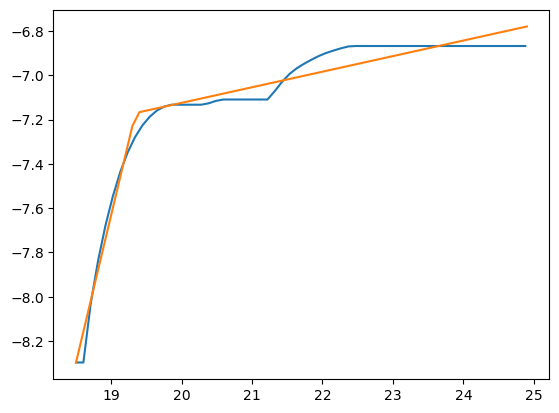

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.334  0.051   1.241    1.428      0.006    0.004      73.0   
m2       0.070  0.005   0.061    0.079      0.000    0.000     368.0   
xinter  19.346  0.038  19.276   19.411      0.004    0.003      78.0   
sigma    0.055  0.005   0.046    0.065      0.000    0.000    5889.0   

        ess_tail  r_hat  
m1         200.0   1.06  
m2         722.0   1.01  
xinter     214.0   1.05  
sigma     9483.0   1.00  
Processing E36
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 139 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


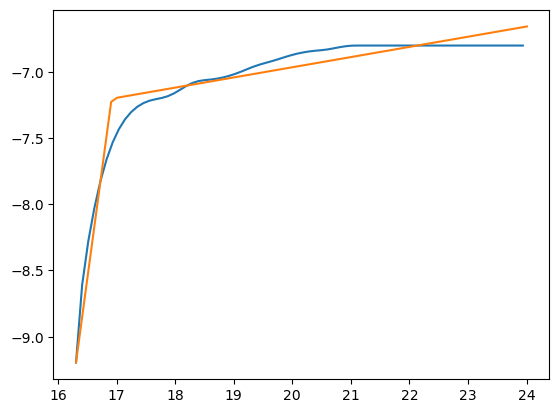

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       3.279  0.183   2.941    3.570      0.046    0.033      18.0   
m2       0.077  0.006   0.065    0.089      0.000    0.000     211.0   
xinter  16.914  0.039  16.858   16.989      0.010    0.007      19.0   
sigma    0.099  0.009   0.084    0.116      0.000    0.000    7210.0   

        ess_tail  r_hat  
m1          64.0   1.17  
m2         416.0   1.02  
xinter      73.0   1.16  
sigma    10140.0   1.00  
Processing E54
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 152 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


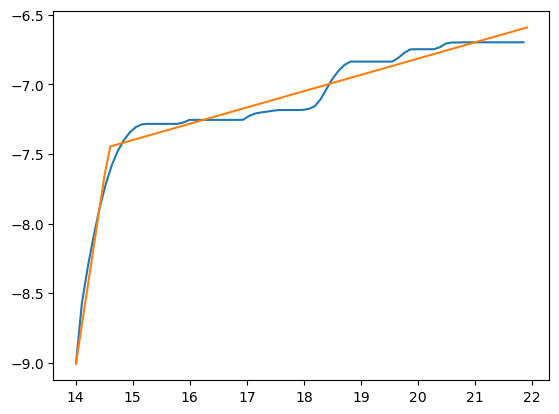

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.706  0.100   2.525    2.915      0.017    0.012      31.0   
m2       0.117  0.004   0.109    0.125      0.000    0.000     335.0   
xinter  14.583  0.024  14.538   14.628      0.004    0.003      36.0   
sigma    0.076  0.006   0.065    0.088      0.000    0.000    5801.0   

        ess_tail  r_hat  
m1          62.0   1.10  
m2         749.0   1.01  
xinter      54.0   1.09  
sigma    11169.0   1.00  
Processing E72
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 150 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


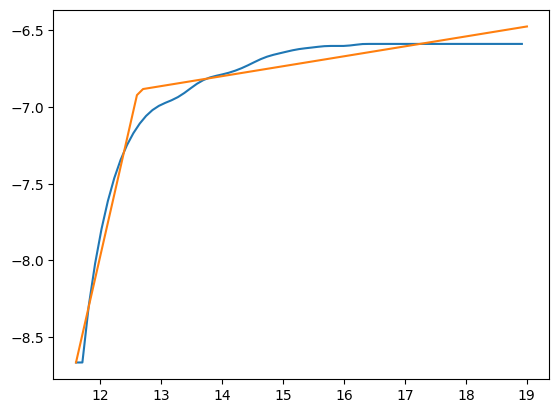

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.744  0.065   1.612    1.853      0.014    0.010      22.0   
m2       0.065  0.006   0.053    0.077      0.000    0.000     266.0   
xinter  12.622  0.046  12.547   12.718      0.010    0.007      23.0   
sigma    0.085  0.008   0.071    0.099      0.000    0.000    5435.0   

        ess_tail  r_hat  
m1          68.0   1.14  
m2         681.0   1.02  
xinter      69.0   1.14  
sigma     9226.0   1.00  
Processing E90
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 167 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


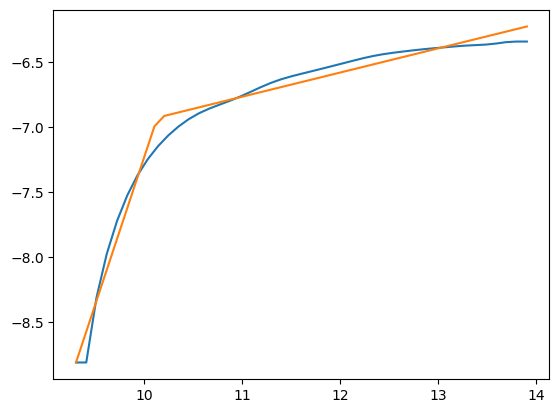

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.268  0.087   2.118    2.437      0.010    0.007      75.0   
m2       0.186  0.014   0.159    0.211      0.001    0.000     471.0   
xinter  10.132  0.041  10.061   10.207      0.005    0.003      78.0   
sigma    0.086  0.010   0.070    0.105      0.000    0.000    4842.0   

        ess_tail  r_hat  
m1         148.0   1.05  
m2        1433.0   1.01  
xinter     154.0   1.04  
sigma     8594.0   1.00  
Processing E108
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 155 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


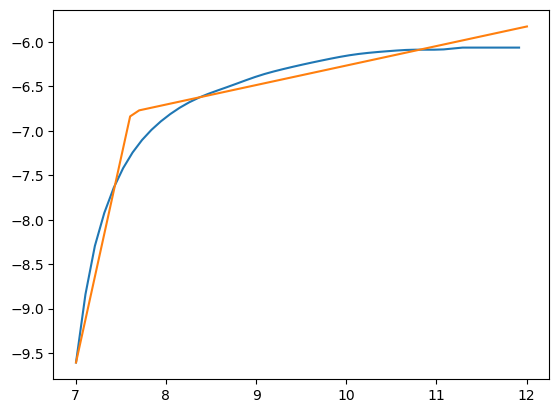

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
m1      4.618  0.328   3.955    5.140      0.048    0.034      51.0      45.0   
m2      0.220  0.022   0.177    0.260      0.002    0.001     211.0     385.0   
xinter  7.614  0.051   7.533    7.723      0.007    0.005      50.0      44.0   
sigma   0.161  0.018   0.129    0.194      0.000    0.000    3175.0    8390.0   

        r_hat  
m1       1.08  
m2       1.01  
xinter   1.07  
sigma    1.00  
Processing E126
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 163 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


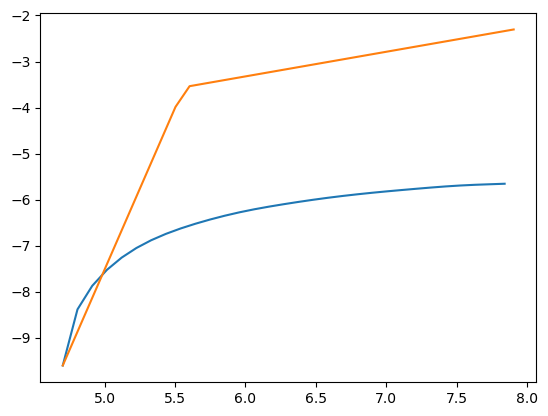

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
m1      7.018  1.401   5.639    9.873      0.453    0.330      13.0      12.0   
m2      0.535  0.296   0.394    0.637      0.034    0.038     181.0      46.0   
xinter  5.565  2.395   4.955    5.200      0.635    0.459      13.0      12.0   
sigma   0.228  0.201   0.129    0.257      0.056    0.041      46.0      13.0   

        r_hat  
m1       1.21  
m2       1.06  
xinter   1.22  
sigma    1.06  
Processing E144
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 170 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


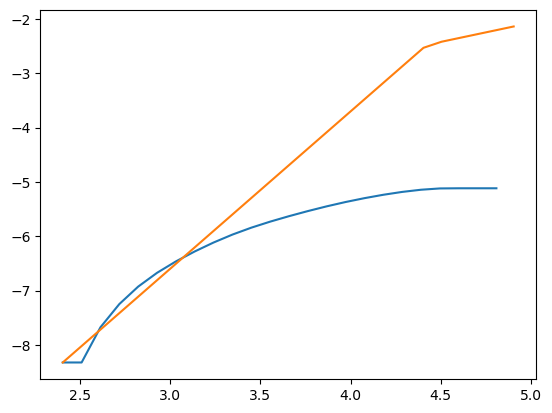

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
m1      2.895  0.361   1.719    3.278      0.129    0.095      23.0      11.0   
m2      0.702  0.375   0.328    1.441      0.059    0.058     169.0      14.0   
xinter  4.423  4.443   2.929   16.418      1.631    1.202      23.0      11.0   
sigma   0.166  0.128   0.085    0.524      0.048    0.035      21.0      11.0   

        r_hat  
m1       1.13  
m2       1.12  
xinter   1.14  
sigma    1.12  
M8
Processing E18
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 171 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


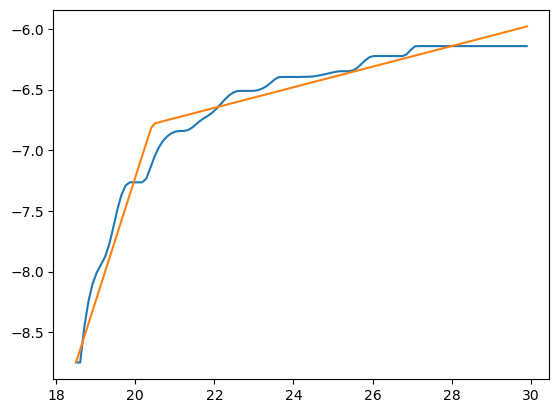

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.018  0.038   0.957    1.090      0.009    0.006      22.0   
m2       0.085  0.005   0.076    0.095      0.001    0.000      66.0   
xinter  20.433  0.093  20.264   20.603      0.021    0.015      20.0   
sigma    0.109  0.008   0.096    0.124      0.000    0.000    4936.0   

        ess_tail  r_hat  
m1          45.0   1.14  
m2         414.0   1.05  
xinter      49.0   1.16  
sigma    11823.0   1.00  
Processing E36
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 172 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


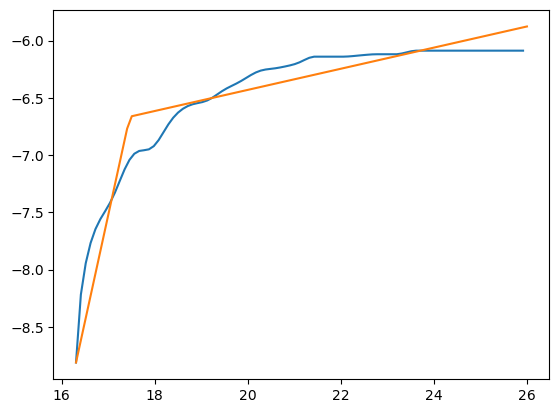

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.858  0.136   1.618    2.124      0.022    0.016      44.0   
m2       0.092  0.009   0.076    0.109      0.001    0.000     217.0   
xinter  17.462  0.100  17.271   17.648      0.015    0.011      46.0   
sigma    0.169  0.013   0.145    0.193      0.000    0.000    7358.0   

        ess_tail  r_hat  
m1          36.0   1.07  
m2         529.0   1.01  
xinter      35.0   1.07  
sigma    11414.0   1.00  
Processing E54
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 170 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


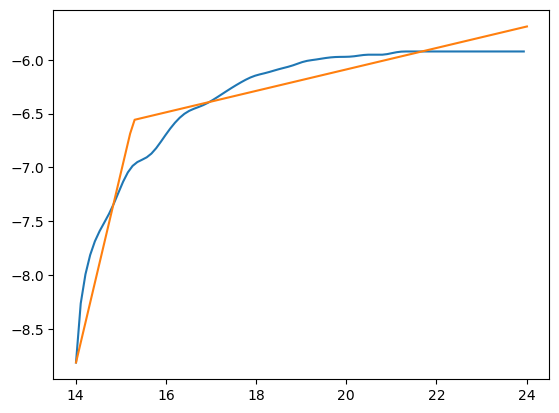

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.773  0.111   1.578    1.995      0.019    0.013      35.0   
m2       0.100  0.009   0.085    0.117      0.001    0.000     269.0   
xinter  15.278  0.098  15.092   15.458      0.017    0.012      36.0   
sigma    0.179  0.013   0.155    0.204      0.000    0.000    8632.0   

        ess_tail  r_hat  
m1          65.0   1.08  
m2         513.0   1.01  
xinter      63.0   1.08  
sigma    12379.0   1.00  
Processing E72
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 169 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


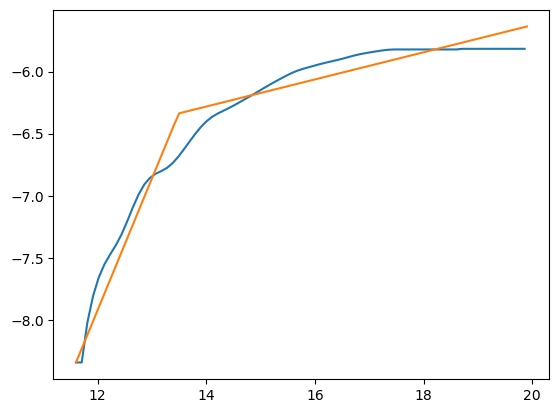

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.060  0.057   0.961    1.176      0.008    0.006      51.0   
m2       0.109  0.012   0.089    0.133      0.001    0.001     106.0   
xinter  13.494  0.145  13.210   13.767      0.020    0.014      51.0   
sigma    0.130  0.011   0.111    0.151      0.000    0.000    5485.0   

        ess_tail  r_hat  
m1         114.0   1.04  
m2         426.0   1.02  
xinter     125.0   1.05  
sigma    11080.0   1.00  
Processing E90
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 160 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


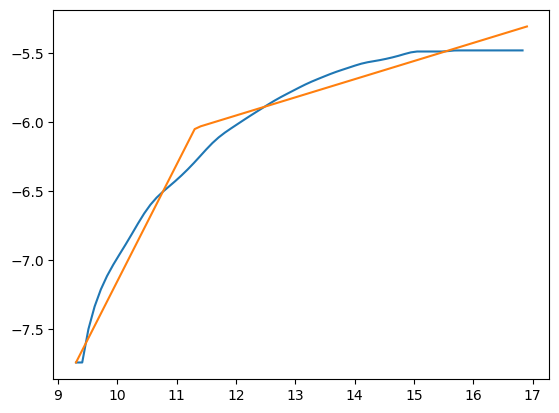

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.845  0.039   0.775    0.923      0.006    0.004      32.0   
m2       0.131  0.012   0.109    0.154      0.001    0.001      80.0   
xinter  11.313  0.149  11.017   11.593      0.026    0.019      31.0   
sigma    0.106  0.009   0.090    0.124      0.000    0.000    5771.0   

        ess_tail  r_hat  
m1         152.0   1.12  
m2         315.0   1.05  
xinter     133.0   1.11  
sigma    10169.0   1.00  
Processing E108
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 160 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


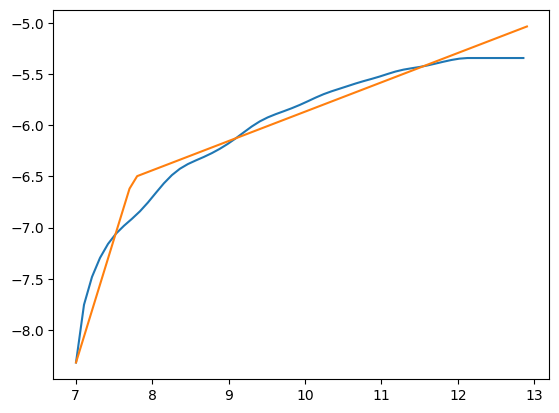

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
m1      2.426  0.311   1.889    3.023      0.064    0.046      21.0      28.0   
m2      0.287  0.018   0.251    0.321      0.003    0.002      54.0     111.0   
xinter  7.747  0.125   7.529    7.999      0.030    0.022      21.0      31.0   
sigma   0.152  0.015   0.125    0.182      0.000    0.000    2989.0    9689.0   

        r_hat  
m1       1.14  
m2       1.05  
xinter   1.14  
sigma    1.00  
Processing E126
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 163 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


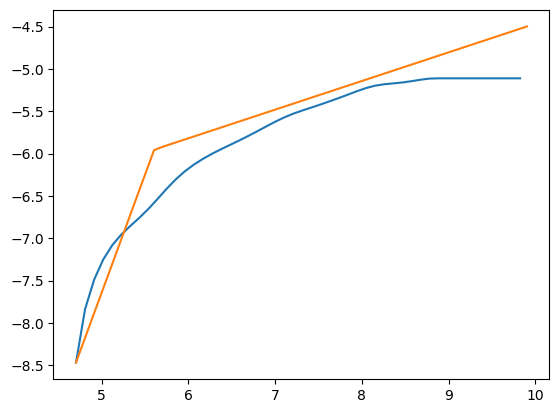

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
m1      2.786  0.410   2.133    3.510      0.075    0.054      32.0      27.0   
m2      0.338  0.115   0.264    0.387      0.010    0.009     134.0     215.0   
xinter  5.606  0.875   5.242    5.781      0.138    0.098      32.0      26.0   
sigma   0.201  0.070   0.155    0.236      0.011    0.008     385.0     130.0   

        r_hat  
m1       1.09  
m2       1.03  
xinter   1.09  
sigma    1.01  
Processing E144
9.583333333333334


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 172 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


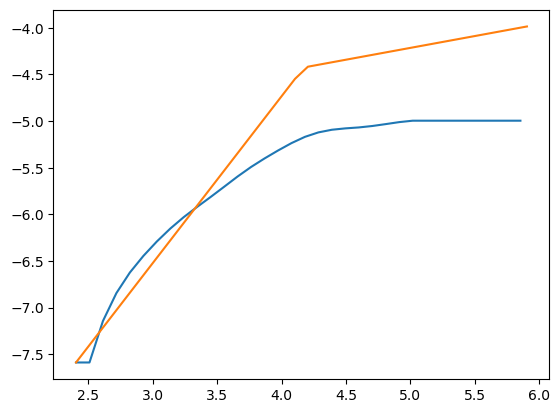

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
m1      1.788  0.171   1.661    1.996      0.043    0.031      45.0      18.0   
m2      0.254  0.284   0.095    0.329      0.050    0.036     261.0      31.0   
xinter  4.172  2.802   3.440    3.840      0.714    0.515      44.0      18.0   
sigma   0.141  0.091   0.091    0.164      0.024    0.017      70.0      17.0   

        r_hat  
m1       1.07  
m2       1.04  
xinter   1.07  
sigma    1.04  


In [6]:
events_list = []
mags_list = []
stas_list = []
hypdist_list = []
xhighs_list = []
m1s_list = []
m2s_list = []
xinters_list = []
sigmas_list = []
trans_time_list = []

# for ii in range(len(events)):
for ii in range(len(rupt_params)):
    
    evt_id = 'M' + str(int(rupt_params[ii,0]))
    mag = int(rupt_params[ii,0])
    print(evt_id)

    # for idx in range(len(snr_array)):
    for idx in range(len(stas_sub)):

        # sta = snr_array['Sta'][idx]
        sta = stas_sub[idx]
        # if evt_id == 'M5' and sta == 'E36':
        #     pass
        # else:
        #     continue
        
        # Figure out the bounds for the MCMC based on the event and hypocentral distance (rainbow plots)
        i = np.where(stas.name.values == sta)[0]
        theo_p_arr = stas.p_arrival.values[i][0]
        # print(theo_p_arr)
        
        xlow = theo_p_arr
        xhigh = get_xhigh(evt_id, sta)
        
        i = np.where(stas.name.values == sta)[0]
        hypdist = stas.hypo_dist_km.values[i][0]
        # print(hypdist)
        int_hypdist = int(hypdist)
        
        both_peak_strain = np.load(path + 'npys_for_mcmc/' + evt_id + '/filter_peak_strain/' + sta + '.npy')
        # both_norm_peak_strain = np.load(path + 'npys_for_mcmc/M' + evt_id + '/norm_peak_strain/' + sta + '.npy')
        
        print('Processing ' + str(sta))
        
        times = both_peak_strain[:,0]
        data = both_peak_strain[:,1]
        log10_data = np.log10(data)
        
        max_time = max(times)
        npts = len(times)
        samp_rate = npts / max_time
        print(samp_rate)
        
        vec_start = int(xlow*samp_rate)
        vec_end = int(xhigh*samp_rate)

        # Split into x and y vectors
        xobserved = times[vec_start:vec_end]
        yobserved = log10_data[vec_start:vec_end]
        x0 = xobserved[0]
        y0 = yobserved[0]
        
        # in order to pass the x variable into the target function it needs to be 
        # converted to a Theano "shared" variable
        pt_xobserved = pytensor.shared(xobserved)
        pt_x0 = pytensor.shared(x0)
        pt_y0 = pytensor.shared(y0)
            
        # MCMC run parameters, these are good numbers for a "production" run. If you are
        # fooling arund these can be lower to iterate faster
        Nburn = 5000 # burn in samples that get discarded
        Nmcmc = 15000 # bump to at least 5-10k
        Nchains = 4
        Ncores = 1
        
        # Bounds for the prior distributions
        m1_low = -1; m1_high = 20
        m2_low = -1; m2_high = 3
        xinter_low = theo_p_arr ; xinter_high = 25 # location of the line slope change
        
        # Define the Bayesian model
        with pm.Model()as model:
            
            # Use normal distributions as priors
            m1 = pm.Uniform('m1', lower = m1_low, upper = m1_high)
            m2 = pm.Uniform('m2', lower = m2_low, upper = m2_high)
            # m1 = pm.Normal('m1', mu = 0.5, sigma = 1)
            # m2 = pm.Normal('m2', mu = -0.1, sigma = 5)
            xinter = pm.Uniform('xinter', lower = xinter_low, upper = xinter_high)
            sigma = pm.HalfCauchy('sigma', beta = 10, initval = 1)
        
            # This is the model
            likelihood = pm.Normal('y', mu = two_straight_lines(pt_xobserved,m1,m2,xinter,pt_x0,pt_y0),
                                    observed = yobserved, sigma = sigma)

            # NUTS sampler (default) is gradient based and won't work, use metropolis
            step = pm.Metropolis(scaling = 0.1)
            
            # This runs the mcmc sampler
            mcmc = pm.sample(Nmcmc, tune = Nburn, chains = Nchains, cores = Ncores, step = step)
        
        # Done, now is post-processing to get the data out of the sampler

        posterior = az.extract(mcmc)
        
        # Unwrap coeficients - WRITE LINES TO SAVE THE ARRAYS!!!
        m1_array = posterior.m1.values
        m1 = np.mean(m1_array)
        # print('m1 mean: ' + str(round(m1,2)))
        
        m2_array = posterior.m2.values
        m2 = np.mean(m2_array)
        # print('m2 mean: ' + str(round(m2,2)))
        
        xinter_array = posterior.xinter.values
        xinter = np.mean(xinter_array)
        # print('xinter Mean: ' + str(round(xinter,2)))
        
        sigma_array = posterior.sigma.values
        sigma = np.mean(sigma_array)

        # Lines!
        b1 = y0 - m1*x0
        b2 = m1*xinter + b1 - m2*xinter
        
        # Make plot to check stuff
        xpredicted = np.arange(xobserved.min(), xobserved.max()+0.1, 0.1)
        ypredicted = m1*xpredicted + b1
        i = np.where(xpredicted > xinter)[0]
        ypredicted[i] = m2*xpredicted[i] + b2
        
        plt.plot(xobserved, yobserved)
        plt.plot(xpredicted, ypredicted)
        plt.show()
        
        # Get one-sigma region (need to obtain a ton of forward models and get stats)
        N = len(posterior.m1.values)
        
        yfit = np.zeros((len(xpredicted), N))
        for k in range(N):
            yfit[:,k] = non_pytensor_two_straight_lines(xpredicted,m1_array[k],m2_array[k],xinter_array[k],x0,y0)
        mu = yfit.mean(1)
        sig = yfit.std(1) * 1.95 #for 95% confidence
        mu_plus = mu + sig
        mu_minus = mu - sig
        
        # Least squares
        mls, bls = np.polyfit(xobserved, yobserved, 1)
        
        # Find the transition point in ypredicted
        diff = np.round(np.diff(ypredicted), decimals = 5)
        # print(diff)
        first_slope = diff[0]
        second_slope = diff[-1]
        try:
            trans_idx = np.where((diff != first_slope) & (diff != second_slope))[0][0] + 1
        except:
            trans_idx = np.where(diff == first_slope)[0][0] + 1
        
        # Get the transition point
        mcmc_trans_x = xpredicted[trans_idx] # Number
        mcmc_trans_y = ypredicted[trans_idx]
        
        # Append things
        events_list.append(evt_id)
        mags_list.append(mag)
        stas_list.append(sta)
        hypdist_list.append(int_hypdist)
        xhighs_list.append(xhigh)
        m1s_list.append(m1)
        m2s_list.append(m2)
        xinters_list.append(xinter)
        sigmas_list.append(sigma)
        trans_time_list.append(mcmc_trans_x)
        
        # Create folder for the event
        array_save_dir = path + 'filter_mcmc_arrays/' + evt_id + '/' + sta + '/'
        if os.path.isdir(array_save_dir):
            pass
        else:
            os.makedirs(array_save_dir)

        np.save(array_save_dir + 'xobserved.npy', xobserved)
        np.save(array_save_dir + 'yobserved.npy', yobserved)
        np.save(array_save_dir + 'xpredicted.npy', xpredicted)
        np.save(array_save_dir + 'ypredicted.npy', ypredicted)
        np.save(array_save_dir + 'forward_mus.npy', mu)
        np.save(array_save_dir + 'foward_sigs.npy', sig)
        
        summary = az.summary(mcmc, fmt = 'wide')
        print(summary)
        summary.to_csv(array_save_dir + 'mcmc_summary.csv', index = False)
        
        # Folder for figures
        fig_save_dir = path + 'filter_mcmc_plots/' + evt_id + '/'
        if os.path.isdir(fig_save_dir):
            pass
        else:
            os.makedirs(fig_save_dir)
        
        az.plot_trace(mcmc)
        # plt.show()
        plt.savefig(fig_save_dir + sta + '_stats_plots.png', format = 'PNG')
        plt.close()

        # Plot all solutions
        fig = plt.figure(dpi = 100)
        ax = fig.add_subplot(111)
        ax.set_title(str(sta))
        
        ax.plot(xobserved, yobserved, color = 'blue', label = 'Observed (log peak strain)')
        ax.plot(xpredicted, ypredicted, color = 'red', label = 'Predicted (MCMC)')
        # ax.plot(xpredicted, mu, color = 'green', linestyle = '--', label = 'yfit')
        # ax.plot(xpredicted, xpredicted * mls + bls, color = 'orange', label = 'np.polyfit least squares')
        ax.scatter(xpredicted[trans_idx], ypredicted[trans_idx], marker = 'o', color = 'black', label = 'Transition at ' + str(round(xpredicted[trans_idx],2)) + ' sec')
        # ax.scatter(closest_trans_x, closest_trans_y, marker = 'o', color = 'green', label = 'Adjusted transition at ' + str(round(closest_trans_x,2)) + ' sec')
        # ax2 = ax.twinx()
        # ax2.plot(xobserved, pythags_arr, color = 'violet')
        # ax2.axhline(closest_trans_x, color = 'violet', linestyle = '--')
        ax.fill_between(xpredicted, mu_plus, mu_minus, color = 'gray', alpha = 0.2, label = '95% confidence') # 95% confidence interval
        ax.set_xlabel('Time (s) - p-wave at 10s')
        ax.set_ylabel('log10 of peak strain')
        # ax.set_xlim(10,13)
        ax.legend()
        
        # plt.show()
            
        plt.savefig(fig_save_dir + sta + '.png', format = 'PNG')
        plt.close()

In [7]:
model.debug()

point={'m1_interval__': array(0.), 'm2_interval__': array(0.), 'xinter_interval__': array(0.), 'sigma_log__': array(0.)}

No problems found


In [8]:
mcmc_array = np.column_stack((np.array(events_list), np.array(mags_list), np.array(stas_list), np.array(hypdist_list),
                             np.array(xhighs_list), np.array(m1s_list), np.array(m2s_list), np.array(xinters_list),
                             np.array(sigmas_list), np.round(np.array(trans_time_list),2)))

np.save(path + 'filter_mcmc_arrays/mcmc_colstack_array.npy', mcmc_array)

In [9]:
pd_mcmc = pd.DataFrame(mcmc_array, columns = ['eq_id', 'mag', 'sta', 'hypdist', 'xhigh', 'm1', 'm2', 'xinter', 'sigma', 'trans_time'])
pd_mcmc.to_csv(path + 'filter_mcmc_arrays/mcmc_results_summary.csv', index = False)

In [10]:
# pd_mcmc

In [11]:
# stas

In [12]:
pd_mcmc = pd.read_csv(path + 'filter_mcmc_arrays/mcmc_results_summary.csv')
times_to_trans = []
p_arrs = []

for idx in range(len(pd_mcmc)):
    
    sta = pd_mcmc.sta.values[idx]
    # print(sta)
    i = np.where(stas.name.values == sta)[0]
    p_arr = stas.p_arrival.values[i][0]
    # print(p_arr)
    trans_time = pd_mcmc.xinter.values[idx]
    # print(trans_time)
    time_to_trans = float(trans_time) - p_arr
    p_arrs.append(p_arr)
    times_to_trans.append(time_to_trans)

pd_mcmc['p_arrival'] = p_arrs
pd_mcmc['time_to_transition'] = times_to_trans
pd_mcmc.to_csv(path + 'filter_mcmc_arrays/mcmc_results_summary_w_transtime.csv', index = False)

In [13]:
# plt.scatter(pd_mcmc.mag.values, pd_mcmc.time_to_transition.values)
# # plt.semilogy()
# plt.show()

# plt.scatter(pd_mcmc.hypdist.values, pd_mcmc.time_to_transition.values)
# # plt.semilogy()
# plt.show();

In [14]:
mcmc = pd.read_csv(path + 'filter_mcmc_arrays/mcmc_results_summary_w_transtime.csv')
mcmc

,eq_id,mag,sta,hypdist,xhigh,m1,m2,xinter,sigma,trans_time,p_arrival,time_to_transition
0,M5,5,E18,111,25,1.188355,0.050015,19.382357,0.069985,19.40,18.567198,0.815159
1,M5,5,E36,97,20,7.781424,0.141056,16.533789,0.129427,16.61,16.298455,0.235334
2,M5,5,E54,83,19,5.764275,0.128457,14.249171,0.091895,14.31,14.014324,0.234847
3,M5,5,E72,68,15,1.680614,0.134060,12.122745,0.070798,12.20,11.684379,0.438366
4,M5,5,E90,54,12,1.408662,0.268101,9.656373,0.083540,9.70,9.356268,0.300105
5,M5,5,E108,40,10,12.597585,0.171319,7.215629,0.099513,7.30,7.031333,0.184296
6,M5,5,E126,25,7,16.106269,0.168572,4.851396,0.087575,4.90,4.717005,0.134390
7,M5,5,E144,11,4,2.377545,0.240919,3.954037,0.131083,2.50,2.483539,1.470498
8,M6,6,E18,111,25,1.327085,0.119745,19.258559,0.060562,19.30,18.567198,0.691361
9,M6,6,E36,97,20,3.646150,0.197210,16.652343,0.078309,16.71,16.298455,0.353887


In [15]:
mcmc_results = pd.read_csv(path + 'filter_mcmc_arrays/mcmc_results_summary_w_transtime.csv')
mcmc_results_array = mcmc_results.values

counter = 0
results = []

for idx in range(len(mcmc_results_array)):
    
    eq_id = str(mcmc_results_array[idx,0])
    sta = str(mcmc_results_array[idx,2])
    hypdist = int(mcmc_results_array[idx,3])
    xhigh = mcmc_results_array[idx,4]
    p_arr = mcmc_results_array[idx,10]
    
    print(eq_id, sta)

    # print(eq_id, sta, hypdist)

    # Figure out the bounds for the MCMC based on the event and hypocentral distance (rainbow plots)
    xlow = p_arr
    
    # print(path + 'npys_for_mcmc/' + evt_id + '/peak_strain/' + sta + '.npy')
    both_peak_strain = np.load(path + 'npys_for_mcmc/' + eq_id + '/filter_peak_strain/' + sta + '.npy')
    # both_norm_peak_strain = np.load(path + 'npys_for_mcmc/M' + evt_id + '/norm_peak_strain/' + sta + '.npy')

    print('Processing ' + str(sta))

    times = both_peak_strain[:,0]
    data = both_peak_strain[:,1]
    log10_data = np.log10(data)

    max_time = max(times)
    npts = len(times)
    samp_rate = npts / max_time
    # print(samp_rate)
    
    vec_start = int(xlow*samp_rate)
    vec_end = int(xhigh*samp_rate)

    xobserved = times[vec_start:vec_end]
    yobserved = log10_data[vec_start:vec_end]
    x0 = xobserved[0]
    y0 = yobserved[0]
    
    m1_slope = float(mcmc_results_array[idx,5])
    m2_slope = float(mcmc_results_array[idx,6])
    int_time = float(mcmc_results_array[idx,7])
    
    diff = m1_slope - m2_slope
    
    int_x_samp = int(int_time*samp_rate)
    
    # mx + b for the lines
    
    b1 = y0 - m1_slope*x0
    b2 = m1_slope*int_time + b1 - m2_slope*int_time
    
    line1_xobs = times[vec_start:int_x_samp]
    line1_ymodel = m1_slope * line1_xobs + b1
    line1_yobs = log10_data[vec_start:int_x_samp]
    
    line2_xobs = times[int_x_samp:vec_end]
    line2_ymodel = m2_slope * line2_xobs + b2
    line2_yobs = log10_data[int_x_samp:vec_end]
    
    xobs = np.append(line1_xobs, line2_xobs)
    ymodel = np.append(line1_ymodel, line2_ymodel)
    yobs = np.append(line1_yobs, line2_yobs)
    
    error_line1 = np.sqrt(np.sum(np.square(np.subtract(line1_ymodel, line1_yobs))))
    error_line2 = np.sqrt(np.sum(np.square(np.subtract(line2_ymodel, line2_yobs))))
    
    error = np.sqrt(np.sum(np.square(np.subtract(ymodel, yobs))))
    # print(error)
    
#     if error <= 15:
#         results.append('g')
#     else:
#         results.append('b')

    # # if diff > 0.1 and error_line1 < 5 and error_line2 < 6.5:
    if diff > 0 and error_line1 < 3.5 and error_line2 < 6.5:
        results.append('g')
    #     plt.title(m1_slope)
    #     # plt.title('Line 1 error: ' + str(round(error_line1,3)) + ', line 2 error: ' + str(round(error_line2,3)))
    #     plt.plot(xobs, yobs, color = 'blue', label = 'Observed data')
    #     plt.plot(xobs, ymodel, color = 'red', label = 'Model result')
    #     plt.legend()
    #     plt.show()
    else:
        results.append('b')
        # plt.title(m1_slope)
        # plt.title('Line 1 error: ' + str(round(error_line1,3)) + ', line 2 error: ' + str(round(error_line2,3)) + '\ndiff: ' + str(round(diff,3)) + ', M2 slope: ' + str(round(m2_slope,4)))
        # plt.plot(xobs, yobs, color = 'blue', label = 'Observed data')
        # plt.plot(xobs, ymodel, color = 'red', label = 'Model result')
        # plt.legend()
        # plt.show()

mcmc_results['two_line_fit_qual'] = results
    
    # plt.title('Line 1 error: ' + str(round(error_line1,3)) + ', line 2 error: ' + str(round(error_line2,3)) + '\ndiff: ' + str(round(diff,3)) + ', M2 slope: ' + str(round(m2_slope,4)))
    # plt.plot(xobs, yobs, color = 'blue', label = 'Observed data')
    # plt.plot(xobs, ymodel, color = 'red', label = 'Model result')
    # plt.legend()
    # plt.show()

        

M5 E18
Processing E18
M5 E36
Processing E36
M5 E54
Processing E54
M5 E72
Processing E72
M5 E90
Processing E90
M5 E108
Processing E108
M5 E126
Processing E126
M5 E144
Processing E144
M6 E18
Processing E18
M6 E36
Processing E36
M6 E54
Processing E54
M6 E72
Processing E72
M6 E90
Processing E90
M6 E108
Processing E108
M6 E126
Processing E126
M6 E144
Processing E144
M7 E18
Processing E18
M7 E36
Processing E36
M7 E54
Processing E54
M7 E72
Processing E72
M7 E90
Processing E90
M7 E108
Processing E108
M7 E126
Processing E126
M7 E144
Processing E144
M8 E18
Processing E18
M8 E36
Processing E36
M8 E54
Processing E54
M8 E72
Processing E72
M8 E90
Processing E90
M8 E108
Processing E108
M8 E126
Processing E126
M8 E144
Processing E144


In [16]:
mcmc_results.to_csv(path + 'filter_mcmc_arrays/mcmc_results_summary_with_quality.csv', index = False)


In [17]:
mcmc_results = pd.read_csv(path + 'filter_mcmc_arrays/mcmc_results_summary_with_quality.csv')
mcmc_results

,eq_id,mag,sta,hypdist,xhigh,m1,m2,xinter,sigma,trans_time,p_arrival,time_to_transition,two_line_fit_qual
0,M5,5,E18,111,25,1.188355,0.050015,19.382357,0.069985,19.40,18.567198,0.815159,g
1,M5,5,E36,97,20,7.781424,0.141056,16.533789,0.129427,16.61,16.298455,0.235334,g
2,M5,5,E54,83,19,5.764275,0.128457,14.249171,0.091895,14.31,14.014324,0.234847,g
3,M5,5,E72,68,15,1.680614,0.134060,12.122745,0.070798,12.20,11.684379,0.438366,g
4,M5,5,E90,54,12,1.408662,0.268101,9.656373,0.083540,9.70,9.356268,0.300105,g
5,M5,5,E108,40,10,12.597585,0.171319,7.215629,0.099513,7.30,7.031333,0.184296,g
6,M5,5,E126,25,7,16.106269,0.168572,4.851396,0.087575,4.90,4.717005,0.134390,g
7,M5,5,E144,11,4,2.377545,0.240919,3.954037,0.131083,2.50,2.483539,1.470498,g
8,M6,6,E18,111,25,1.327085,0.119745,19.258559,0.060562,19.30,18.567198,0.691361,g
9,M6,6,E36,97,20,3.646150,0.197210,16.652343,0.078309,16.71,16.298455,0.353887,g


In [18]:
good_results = mcmc_results[mcmc_results['two_line_fit_qual'] == 'g']
bad_results = mcmc_results[mcmc_results['two_line_fit_qual'] == 'b']

bad_results

,eq_id,mag,sta,hypdist,xhigh,m1,m2,xinter,sigma,trans_time,p_arrival,time_to_transition,two_line_fit_qual
14,M6,6,E126,25,7,5.437418,0.371857,6.385094,0.189062,6.4,4.717005,1.668088,b
22,M7,7,E126,25,8,7.017941,0.535233,5.565016,0.228125,5.6,4.717005,0.848011,b
23,M7,7,E144,11,5,2.894851,0.701946,4.423045,0.166334,4.5,2.483539,1.939506,b


In [19]:
# Calculate earthquake source durations

# Get M0 from Mw, then use relation in Melgar and Hayes, 2017 to get duration

mags_for_relation = np.arange(5,8,0.05)
# print(mags_for_dur)

# Preferred params for source duration
apref_sd = -6.407
bpref_sd = 0.385

apref_rt = -5.323
bpref_rt = 0.293

source_durs = []
rise_times = []

for Mw in mags_for_relation:
    
    M0 = 10**(1.5*Mw + 9.05)
    # print(M0)
    
    log_sd = apref_sd + bpref_sd * np.log10(M0)
    source_dur = 10**log_sd
    source_durs.append(source_dur)
    
    log_rt = apref_rt + bpref_rt * np.log10(M0)
    rise_time = 10**log_rt
    rise_times.append(rise_time)
    

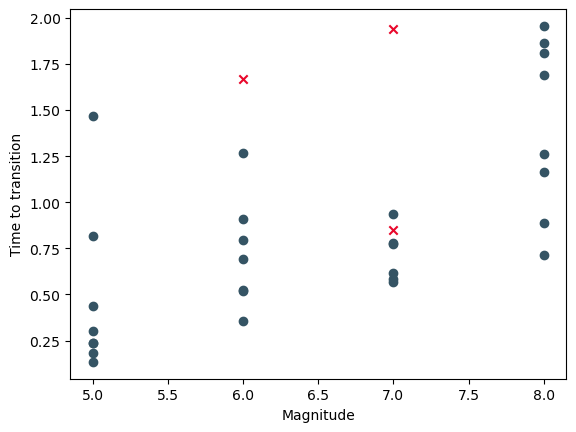

In [27]:
plt.scatter(good_results.mag.values, good_results.time_to_transition, marker = 'o', color = '#355464')
plt.scatter(bad_results.mag.values, bad_results.time_to_transition, marker = 'x', color = '#E9072B')
# plt.semilogy()
plt.xlabel('Magnitude')
plt.ylabel('Time to transition');


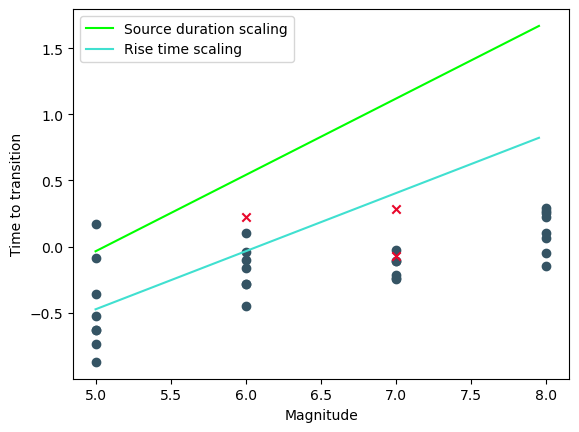

In [21]:
plt.scatter(good_results.mag.values, np.log10(good_results.time_to_transition), marker = 'o', color = '#355464')
plt.scatter(bad_results.mag.values, np.log10(bad_results.time_to_transition), marker = 'x', color = '#E9072B')
plt.plot(mags_for_relation, np.log10(source_durs), color = 'lime', label = 'Source duration scaling')
plt.plot(mags_for_relation, np.log10(rise_times), color = 'turquoise', label = 'Rise time scaling')
# plt.semilogy()
plt.xlabel('Magnitude')
plt.ylabel('Time to transition')
plt.legend();

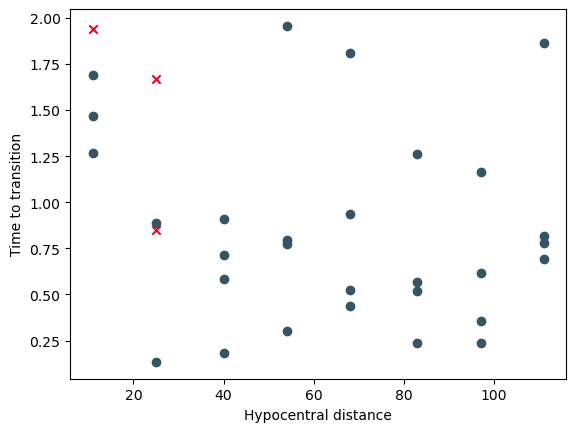

In [22]:
plt.scatter(good_results.hypdist.values, good_results.time_to_transition, marker = 'o', color = '#355464')
plt.scatter(bad_results.hypdist.values, bad_results.time_to_transition, marker = 'x', color = '#E9072B')
# plt.semilogy()
plt.xlabel('Hypocentral distance')
plt.ylabel('Time to transition');


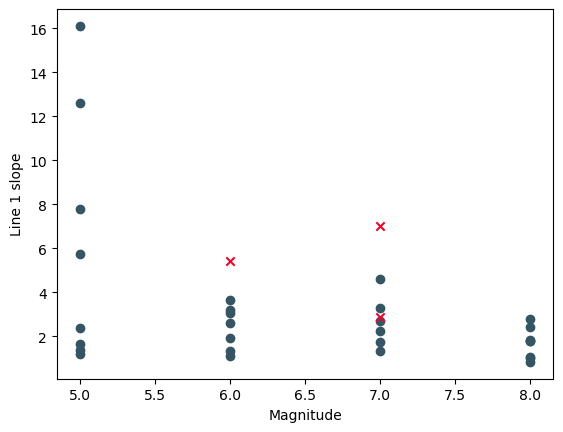

In [23]:
plt.scatter(good_results.mag.values, good_results.m1, marker = 'o', color = '#355464')
plt.scatter(bad_results.mag.values, bad_results.m1, marker = 'x', color = '#E9072B')
# plt.semilogy()
plt.xlabel('Magnitude')
plt.ylabel('Line 1 slope');


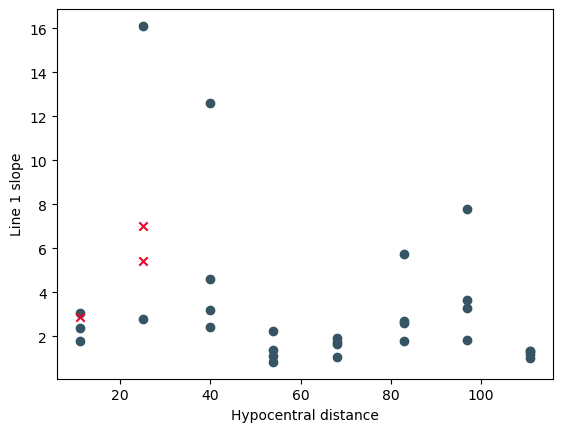

In [24]:
plt.scatter(good_results.hypdist.values, good_results.m1, marker = 'o', color = '#355464')
plt.scatter(bad_results.hypdist.values, bad_results.m1, marker = 'x', color = '#E9072B')
# plt.semilogy()
plt.xlabel('Hypocentral distance')
plt.ylabel('Line 1 slope');


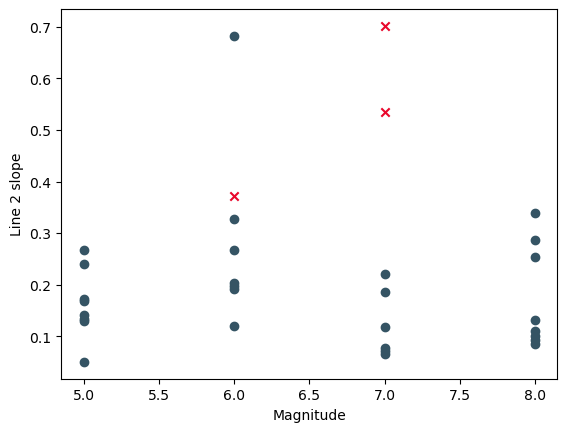

In [25]:
plt.scatter(good_results.mag.values, good_results.m2, marker = 'o', color = '#355464')
plt.scatter(bad_results.mag.values, bad_results.m2, marker = 'x', color = '#E9072B')
# plt.semilogy()
plt.xlabel('Magnitude')
plt.ylabel('Line 2 slope');


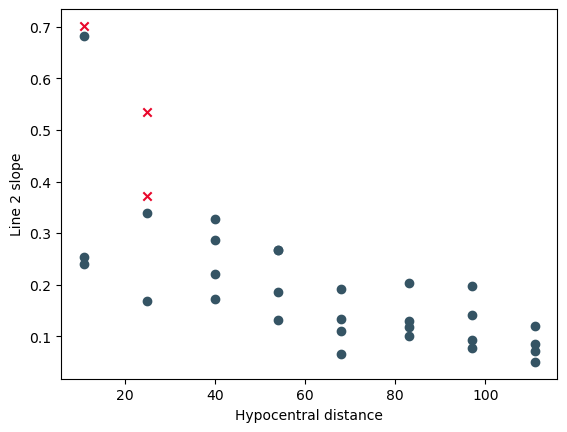

In [26]:
plt.scatter(good_results.hypdist.values, good_results.m2, marker = 'o', color = '#355464')
plt.scatter(bad_results.hypdist.values, bad_results.m2, marker = 'x', color = '#E9072B')
# plt.semilogy()
plt.xlabel('Hypocentral distance')
plt.ylabel('Line 2 slope');
